In [1]:
from scripts.benchmark_data_scripts.data_preprocessing import load_data, preprocess_data

training_data, ground_truth = load_data(path="../../data/benchmark_data")
meta_learner_data = preprocess_data(training_data, ground_truth)

# Define feature columns, outcome, treatment, and true CATE for each hypothesis
covariates = [ "AnswerValue", "CorrectAnswer", "QuestionSequence", "ConstructId"]
outcome_col = "IsCorrect"
treatment_col = "Treatment"
meta_learner_data.head()


C:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\scripts\benchmark_data_scripts\data_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_group["Treatment"] = 1
C:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\scripts\benchmark_data_scripts\data_preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group["Treatment"] = 0


,Treatment,IsCorrect,AnswerValue,CorrectAnswer,QuestionSequence,ConstructId,TrueCATE_p,TrueCATE_k
682,1,0.0,1.0,4.0,2,3133,-0.107143,-0.083333
683,1,0.0,4.0,2.0,2,3133,-0.107143,-0.083333
684,1,1.0,4.0,4.0,4,3133,-0.107143,-0.083333
685,1,1.0,4.0,4.0,1,3133,-0.107143,-0.083333
686,1,1.0,3.0,3.0,2,3133,-0.107143,-0.083333


Estimated Average CATE (PSM): 0.043703007518796994


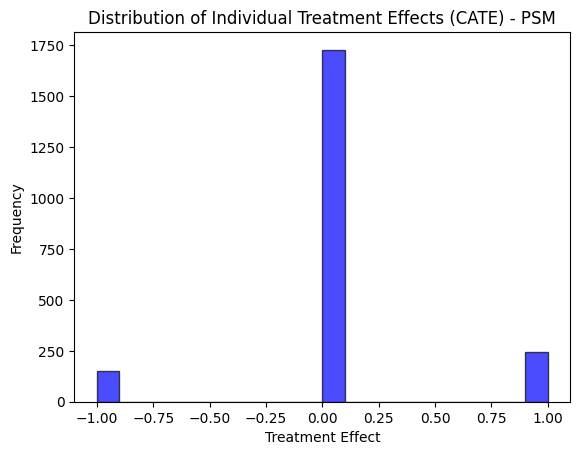

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Define covariates, treatment column, and outcome column
covariates = ["AnswerValue", "CorrectAnswer", "QuestionSequence", "ConstructId"]
outcome_col = "IsCorrect"
treatment_col = "Treatment"

# Load the dataset (ensure it's preprocessed)
data = meta_learner_data


# Step 2: Estimate the propensity score using logistic regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(data[covariates], data[treatment_col])
data['propensity_score'] = logistic_model.predict_proba(data[covariates])[:, 1]

# Step 3: Perform Propensity Score Matching (PSM) - Nearest Neighbor Matching
treated = data[data[treatment_col] == 1]
control = data[data[treatment_col] == 0]

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Match treated individuals with control individuals
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

# Step 4: Estimate CATE for PSM
cate = matched_treated[outcome_col] - matched_control[outcome_col]
print(f"Estimated Average CATE (PSM): {cate.mean()}")

# Save CATE estimates to a CSV file
cate_df = pd.DataFrame({'CATE': cate})
cate_df.to_csv('../../results/benchmark_data_results/psm_results/cate_psm.csv', index=False)

# Step 5: Display distribution of individual CATE estimates for PSM
plt.hist(cate, bins=20, edgecolor='k', alpha=0.7, color="blue")
plt.title('Distribution of Individual Treatment Effects (CATE) - PSM')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract ground truth CATE values for both hypotheses
true_cate_p = matched_treated['TrueCATE_p'].reset_index(drop=True)
true_cate_k = matched_treated['TrueCATE_k'].reset_index(drop=True)

# RMSE Calculation
rmse_p = np.sqrt(mean_squared_error(true_cate_p, cate))
rmse_k = np.sqrt(mean_squared_error(true_cate_k, cate))

# Bias Calculation
bias_p = np.mean(cate - true_cate_p)
bias_k = np.mean(cate - true_cate_k)

# Variance Calculation
variance_p = np.var(cate)
variance_k = np.var(cate)

# Print Evaluation Results
print(f"Evaluation Metrics for Hypothesis P:")
print(f"  RMSE: {rmse_p}")
print(f"  Bias: {bias_p}")
print(f"  Variance: {variance_p}")

print(f"\nEvaluation Metrics for Hypothesis K:")
print(f"  RMSE: {rmse_k}")
print(f"  Bias: {bias_k}")
print(f"  Variance: {variance_k}")


Evaluation Metrics for Hypothesis P:
  RMSE: 0.45203557301349745
  Bias: -0.09509935556015038
  Variance: 0.185590047133812

Evaluation Metrics for Hypothesis K:
  RMSE: 0.4904160284568566
  Bias: -0.19135785877067668
  Variance: 0.185590047133812


C:\Users\dell\AppData\Local\Temp\ipykernel_6572\4020536195.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cate, label="PSM-Estimated CATE", color="blue", shade=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_6572\4020536195.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_cate_p, label="True CATE (P)", color="orange", shade=True)


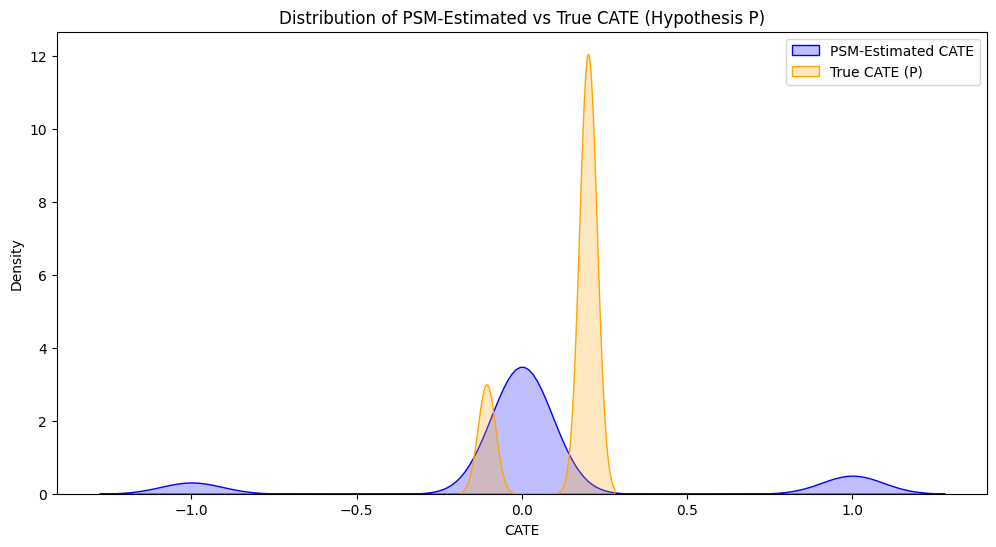

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(cate, label="PSM-Estimated CATE", color="blue", shade=True)
sns.kdeplot(true_cate_p, label="True CATE (P)", color="orange", shade=True)
plt.title("Distribution of PSM-Estimated vs True CATE (Hypothesis P)")
plt.xlabel("CATE")
plt.legend()
plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_6572\1247455622.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cate, label="PSM-Estimated CATE", color="blue", shade=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_6572\1247455622.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_cate_k, label="True CATE (k)", color="orange", shade=True)


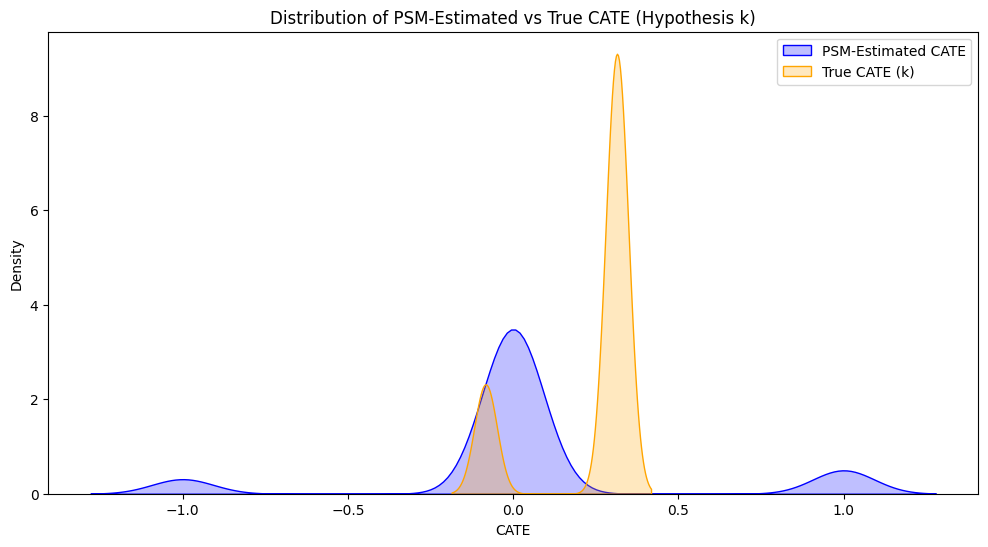

In [5]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(cate, label="PSM-Estimated CATE", color="blue", shade=True)
sns.kdeplot(true_cate_k, label="True CATE (k)", color="orange", shade=True)
plt.title("Distribution of PSM-Estimated vs True CATE (Hypothesis k)")
plt.xlabel("CATE")
plt.legend()
plt.show()
